<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [52]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split


for dirname, _, filenames in os.walk('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/train_transaction.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/train_identity.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/original_data.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/num_sign_col.txt
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/num_sign_col_mice.txt
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/cat_sign_col.txt
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted_old/fitted.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted_old/cat_sign_col.txt
/content/drive/MyDrive/Tesi_magistral

In [53]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

# Preprocessing

## Feature scaling

Implemento il min max scaling delle features. 

Riferimento: https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

In [54]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv'):
  correlation_data = min_max_scaling(correlation_data)
  correlation_data.to_csv(r'./corr_data.csv')

if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  correlation_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv')

Riferimento `save_model` e `load_model`: https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn

Riferimento confusion matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


### Dataset merging

Funzione che ritorna la lista delle colonne significative. 

In [55]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

Rimpiazzo i missing values in categorical data con unknown. 

Unisco i dataset numerici e categorici nel dataframe data. 

Riferimento fillna: https://jamesrledoux.com/code/imputation

In [56]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  col_to_drop = col_not_sign(categorical_data, cat_sign_col)
  categorical_data = categorical_data.drop(col_to_drop, axis=1)
  categorical_data = categorical_data.fillna('unknown')
  data = pd.merge(correlation_data, categorical_data, left_on='TransactionID', right_on='TransactionID', how='left')
  del correlation_data, categorical_data, numerical_data
  data.to_csv(r'./data.csv')

data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

## One hot encoding

One hot encoding delle features categoriche. Serve per lo smote e easy ensemble. 

Bisogna farlo prima dello split del dataset poichè rischio di perdere delle colonne. 

In [57]:
data = pd.get_dummies(data)

In [58]:
cols = mf.get_col(data)

Seleziono i dati appartenenti ai primi 60 giorni. 

Se ne seleziono di più, l'easy ensemble non va. 

In [59]:
data = mf.select_days(data, 60)

In [60]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
time = data['TransactionDT'].values.reshape(-1,1)
# t = min_max_scaler.fit_transform(time)
data['TransactionDT'] = min_max_scaler.fit_transform(time)

Splitto il dataset in train, validation e test set. 

In [61]:
X_train, X_val, y_train, y_val = mf.split(data, test_size = 0.2)
del data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Undersampling: Easy Ensemble

L'easy ensemble tramite un metodo unsupervised divide il dataset in diversi dataset undersampled. 

Documentazione easy ensemble: http://glemaitre.github.io/imbalanced-learn/generated/imblearn.ensemble.EasyEnsemble.html#imblearn.ensemble.EasyEnsemble

Esempio applicazio ee: http://glemaitre.github.io/imbalanced-learn/auto_examples/ensemble/plot_easy_ensemble.html?highlight=easy%20ensemble

In [62]:
X_trainres, y_trainres = mf.easy_ensemble(5, X_train, y_train)

In [63]:
X_trainres_df = pd.DataFrame(data = X_trainres[0], columns = cols)
del X_trainres

# SVM

Riferimento: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

In [70]:
from sklearn.svm import LinearSVC

clf = LinearSVC(max_iter=100000 ,random_state=0, tol=1e-4, class_weight='balanced',  penalty= 'l1', loss='squared_hinge', dual = False )
clf.fit(X_trainres_df.drop(columns=['TransactionID']), y_trainres[0])

LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=100000,
          multi_class='ovr', penalty='l1', random_state=0, tol=0.0001,
          verbose=0)

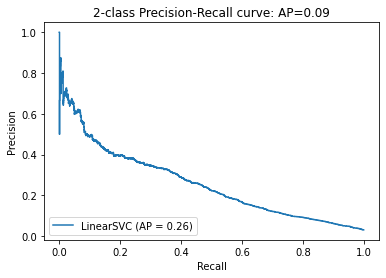

In [71]:
mf.ap_metric(clf, X_val.drop(columns=['TransactionID']), y_val, proba = False)

[[34221  8591]
 [  339  1010]]


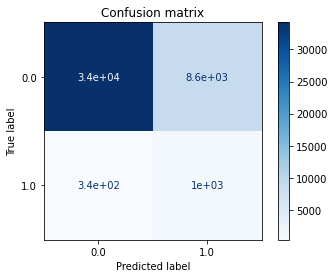

In [72]:
mf.conf_matrix(clf,X_val.drop(columns=['TransactionID']),y_val)